# Importando módulos 

In [3]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter

import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs Directories

In [4]:
#FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
#MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
#EVENTS_FILES = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/"
#EVENTS_GLIDER_FILES = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/"
#QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
#METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/METADATA/df_campanha_glider.feather'
#MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
#LOCAL_EVENTS_TABLE = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/TERREMOTOS_SISBRA_2022/iag_catalogo_costa.csv"

# --------------------------------------------------------------------------------------------
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA/"
EVENTS_FILES = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/"
EVENTS_GLIDER_FILES = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/"
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/METADATA/df_campanha_glider.feather'
MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
LOCAL_EVENTS_TABLE = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/event_files/iag_catalogo_costa.csv"


# Looking for stations files:

In [5]:
selected_events = glob.glob(EVENTS_FILES+'*/*/*/*/*')

In [7]:
ev_lst = []
for ev_time_path in selected_events:
    ev_lst.append(ev_time_path.split('/')[-1])

In [8]:
ev_time_lst = sorted(list(set(ev_lst)))

In [9]:
selected_ev_folder_lst = []
for ev in ev_time_lst:
    temp = []
    for ev_path in selected_events:
        if ev in ev_path:
            temp.append(ev_path)
    selected_ev_folder_lst.append(temp)

In [10]:
st_ev_lst = []*len(selected_ev_folder_lst)
ev_coord_lst = []
for k in selected_ev_folder_lst:
    st = obspy.Stream()
    for i in k:
        ev_Z_file = glob.glob(i+'/*.Z')
        if len(ev_Z_file) > 0:
            trace = obspy.read(ev_Z_file[0])[0]
            trace.stats.distance = trace.stats.sac.dist 
            # Set the latitude and longitude 
            trace.stats.coordinates = {'latitude':trace.stats.sac.stla, 'longitude':trace.stats.sac.stlo}
            ev_coord = (trace.stats.sac.evla,trace.stats.sac.evlo)
            st += trace
    ev_coord_lst.append(ev_coord)
    st_ev_lst.append(st)

# Looking for gliders files:

In [11]:
selected_glider_events = glob.glob(EVENTS_GLIDER_FILES+'*/*/*/*/*')

In [12]:
selected_glider_ev_folder_lst = []
for ev in ev_time_lst:
    temp = []
    for ev_path in selected_glider_events:
        if ev in ev_path:
            temp.append(ev_path)
    selected_glider_ev_folder_lst.append(temp)

In [14]:
st_glider_ev_lst = []*len(selected_glider_ev_folder_lst)
ev_coord_lst = []
for k in selected_glider_ev_folder_lst:
    st = obspy.Stream()
    for i in k:
        ev_Z_file = glob.glob(i+'/*.H')
        if len(ev_Z_file) > 0:
            trace = obspy.read(ev_Z_file[0])[0]
            trace.stats.distance = trace.stats.sac.dist 
            # Set the latitude and longitude 
            trace.stats.coordinates = {'latitude':trace.stats.sac.stla, 'longitude':trace.stats.sac.stlo}
            ev_coord = (trace.stats.sac.evla,trace.stats.sac.evlo)
            st += trace
    ev_coord_lst.append(ev_coord)
    st_glider_ev_lst.append(st)

In [15]:
ev_time_UTC_lst = []
for i in ev_time_lst:      
        ev_time_UTC_lst.append(UTCDateTime.strptime(i[:17],format='%Y.%j.%H.%M.%S'))

# Figure REGIONAL


In [19]:
glob.glob(QUAKEXML_FOLDER+'*')

['/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/event_2020_03_25_brazil.xml',
 '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/CMTSOLUTIONS.xml',
 '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/FIGURES']

In [ ]:
#########################################################################################################################################################
#Figure REGIONAL

# Matching the events files with the catalog:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS.xml')
model = TauPyModel(model="iasp91")

for id,st_p in enumerate(st_ev_lst):
    cat2 = cat.filter("time >= "+UTCDateTime.strftime(ev_time_UTC_lst[id]-60,format='%Y-%m-%dT%H:%M:%S'),"time <= "+UTCDateTime.strftime(ev_time_UTC_lst[id]+60,format='%Y-%m-%dT%H:%M:%S'))
    if len(cat2) > 0 and len(st_glider_ev_lst[id]) > 0:
        ev = cat2[0]
        event = ev.origins[-1].time
        ev_lat = ev.origins[-1].latitude
        ev_long = ev.origins[-1].longitude
        ev_depth = ev.origins[-1].depth/1000
   
        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot()
        
        for st_plot in st_p:
            st_plot.filter('lowpass',freq=3,corners=4,zerophase=True)
            st_plot.taper(type='cosine',max_percentage=0.1)
            st_plot.detrend('linear')
            st_plot.detrend('demean')
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_plot.stats.sac.stla,st_plot.stats.sac.stlo)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=["P"])
            if len(arrival) > 0:
                event_time = event+arrival[0].time
          
                times = [mdates.date2num((event+arrival[0].time)+(i-30)) for i in st_plot.times()]
    
                ax.plot(times[1000:20000],gcarc+preprocessing.normalize([st_plot.data[1000:20000]])[0]*10,c='grey',ls='-',lw=0.5)
                ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3)
                ax.text(x=times[1000],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
            
        for st_glider_plot in st_glider_ev_lst[id]:
            st_glider_plot.filter('lowpass',freq=3,corners=4,zerophase=True)
            st_glider_plot.taper(type='cosine',max_percentage=0.1)
            st_glider_plot.detrend('linear')
            st_glider_plot.detrend('demean')

            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_glider_plot.stats.sac.stla,st_glider_plot.stats.sac.stlo)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=["P","pP"])
            if len(arrival) > 0:
    
                event_time = event+arrival[0].time
                
                times_glider = [mdates.date2num((event+arrival[0].time)+(i-30)) for i in st_glider_plot.times()]
    
                ax.plot(times_glider[1000:20000],gcarc+preprocessing.normalize([st_glider_plot.data[1000:20000]])[0]*15,c='k',ls='-',lw=0.5,label='Lowpassed 3 Hz')
                ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3,label='P-wave arrival')
                ax.text(x=times_glider[1000],y=gcarc,s=st_glider_plot.stats.station+'.'+st_glider_plot.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))
                
        ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+' / Dep: '+str(round(ev_depth))+' km',fontsize=15)
        ax.set_ylabel('Epicentral distance ($^\circ$)')
        ax.legend(loc='lower left')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # ----------------------------------------------------------------------------------------------------------
        # focal mechanisms
        # ----------------------------------------------------------------------------------------------------------

        newax = fig.add_axes([0.6, 0.0, 0.4,  0.4])

        moment_tensor = ev.focal_mechanisms[0].moment_tensor
        mrr = moment_tensor.tensor.m_rr
        mtt = moment_tensor.tensor.m_tt
        mpp = moment_tensor.tensor.m_pp
        mrt = moment_tensor.tensor.m_rt
        mrp = moment_tensor.tensor.m_rp
        mtp = moment_tensor.tensor.m_tp
        mt = [mrr, mtt, mpp, mrt, mrp, mtp]

        bball = beach(fm=mt, xy=(0.5, 0.5),size=500, width=1, facecolor='b')
        
        # Configura os eixos e adiciona a coleção
        newax.add_collection(bball)
        newax.set_xlim(-1, 1)
        newax.set_ylim(-1, 1)
        newax.set_aspect('equal')
        newax.axis('off')
        
        # ----------------------------------------------------------------------------------------------------------
        # Adding global location map
        # ----------------------------------------------------------------------------------------------------------
        # Limit the extent of the map to a small longitude/latitude range.
        latmin=-27
        latmax=-22
        lonmin=-50
        lonmax=-40
        
        # inset location relative to main plot (ax) in normalized units
        inset_x = 0
        inset_y = 1
        inset_size = 0.4

        # Adding Geoaxes
        ax_map = plt.axes([0.05, 0.5, 0.3, 0.3], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
        ax_map.set_global()

        # Adding background map 
        ax_map.add_feature(cfeature.LAND)
        ax_map.add_feature(cfeature.OCEAN)
        ax_map.add_feature(cfeature.COASTLINE)

        ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
        ax_map.scatter(st_glider_plot.stats.sac.stlo,st_glider_plot.stats.sac.stla,color="r",marker='^',s=50,transform=ccrs.PlateCarree())
        ax_map.plot([st_glider_plot.stats.sac.stlo, ev_long], [st_glider_plot.stats.sac.stla, ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
      
        # ----------------------------------------------------------------------------------------------------------
        # Saving figure
        os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/',exist_ok=True)
        fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/'+'event_mseed_'+ev.origins[0].time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+ev.event_descriptions[0].text+'.png',pad_inches=0.01,dpi=100)
        plt.close()

# Figure LOCAL


In [38]:
def cake_arrival_times(model,event_depth_km,sensor_depth_km,distance_km,ocean):
    '''
    Input:
    
    model = path to the cake model (.nd)
    event_depth = depth of the earthquake/seismic event (km)
    sensor_depth = depth of the sensor (km)
    distance = epicentral distance (km)
    ocean =  Is this station in the ocean?  ('True' or 'False')
    
    Output:
    Dataframe (slow/dist/time/take/inci/effi/spre/phase/used)
    '''
    
    if ocean == True and distance_km < 150:
        '''
        Seismic waves arriving at stations at local distances of up to about 150 km have traveled exclusively or dominatingly through the crust or the sub-crustal uppermost mantle.
        Source: https://earthquake.tmd.go.th/file_downloads/wave_interpret/PartChapter%202.pdf
        '''
        command = 'cake arrivals --model='+model+' --sdepth='+str(event_depth_km)+' --rdepth='+str(sensor_depth_km)+' --distances='+str(distance_km)+" --phases='p(seafloor)p,s(seafloor)p,s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p'"
        proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
        (out, err) = proc.communicate()
        results = out.splitlines()
    
        # creating the dataframe with the results
        keys = results[0].split()
        lst_cake_results = []
        for i in results[3:]:
            values = i.split()
            lst_cake_results.append(dict(zip(keys, values)))
    
        df_cake = pd.DataFrame(lst_cake_results)
        if len(df_cake) > 0:

            # getting arrival time
            P_time = df_cake['time'][df_cake['used'] == '(p(seafloor)p)'].values[0]            
            return P_time    
        
    if ocean == False and distance_km < 150:
        command = 'cake arrivals --model='+model+' --sdepth='+str(event_depth_km)+' --rdepth='+str(sensor_depth_km)+' --distances='+str(distance_km)+" --phases='p,s'"
        proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
        (out, err) = proc.communicate()
        results = out.splitlines()
    
        # creating the dataframe with the results
        keys = results[0].split()
        lst_cake_results = []
        for i in results[3:]:
            values = i.split()
            lst_cake_results.append(dict(zip(keys, values)))
    
        df_cake = pd.DataFrame(lst_cake_results)
        if len(df_cake) > 0:
            
            # getting arrival time
            P_time = df_cake['time'][df_cake['used'] == '(p)'].values[0]
            return P_time          
    
    if ocean == False and distance_km > 150:  
        gcarc = obspy.geodetics.kilometer2degrees(distance_km)
        command = 'cake arrivals --model='+model+' --sdepth='+str(event_depth_km)+' --rdepth='+str(sensor_depth_km)+' --distances='+str(gcarc)+" --degrees --phases='P,S'"
        proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
        (out, err) = proc.communicate()
        results = out.splitlines()
    
        # creating the dataframe with the results
        keys = results[0].split()
        lst_cake_results = []
        for i in results[3:]:
            values = i.split()
            lst_cake_results.append(dict(zip(keys, values)))
    
        df_cake = pd.DataFrame(lst_cake_results)
        if len(df_cake) > 0:
        
            # getting arrival time
            P_time = df_cake['time'][df_cake['used'] == '(P)'].values[0]
            return P_time  

        
    if ocean == True and distance_km > 150:  
        gcarc = obspy.geodetics.kilometer2degrees(distance_km)
        command = 'cake arrivals --model='+model+' --sdepth='+str(event_depth_km)+' --rdepth='+str(sensor_depth_km)+' --distances='+str(gcarc)+" --degrees --phases='P,S,S(seafloor)p,s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p'"
        proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
        (out, err) = proc.communicate()
        results = out.splitlines()
    
        # creating the dataframe with the results
        keys = results[0].split()
        lst_cake_results = []
        for i in results[3:]:
            values = i.split()
            lst_cake_results.append(dict(zip(keys, values)))
    
        df_cake = pd.DataFrame(lst_cake_results)
        if len(df_cake) > 0:
            
            # getting arrival time
            P_time = df_cake['time'].values[0]
            return P_time  

Traceback (most recent call last):
  File "/home/sysop/Programs/anaconda3/bin/cake", line 11, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/pyrocko/apps/cake.py", line 724, in main
    c = optparse(
        ^^^^^^^^^
  File "/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/pyrocko/apps/cake.py", line 355, in optparse
    d['model'] = cake.load_model(
                 ^^^^^^^^^^^^^^^^
  File "/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/pyrocko/cake.py", line 4243, in load_model
    mod = LayeredModel.from_scanlines(reader)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/pyrocko/cake.py", line 3612, in from_scanlines
    for z, material, name in producer:
  File "/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/pyrocko/cake.py", line 4070, in read_nd_model
    with open(fn, 'r') as f:
         ^^^^^^^^^^^^^
File

IndexError: list index out of range

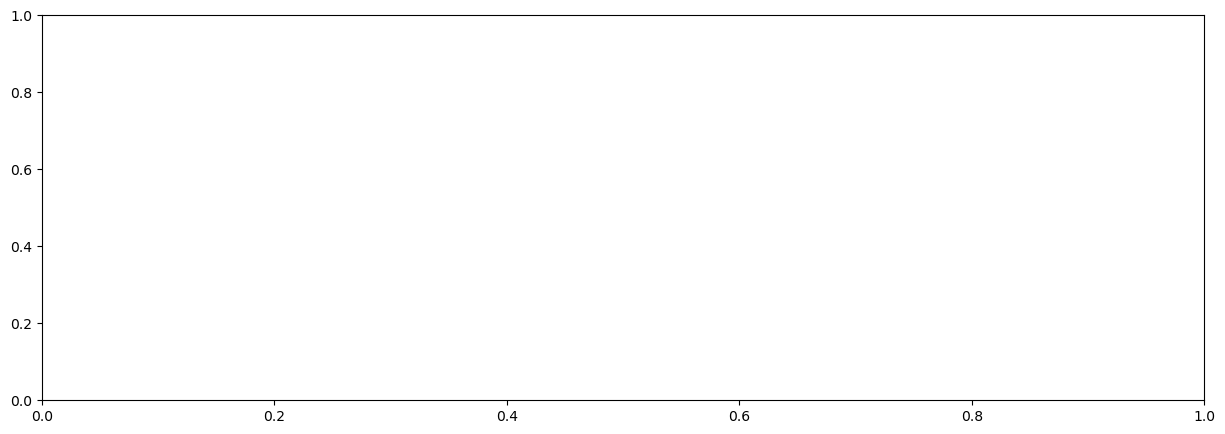

In [39]:
#########################################################################################################################################################
#Figure LOCAL

# Matching the events files with the catalog:
model = TauPyModel(model="iasp91")

events = pd.read_csv(LOCAL_EVENTS_TABLE,sep=',')
events['time'] = events.apply(lambda row: UTCDateTime(row.origin), axis=1)
events['date'] = events.apply(lambda row: UTCDateTime(row.origin).date, axis=1)

for id,st_p_local in enumerate(st_ev_lst):
    ev_file = events[(events['date'] == ev_time_UTC_lst[id].date)]
    if ev_file.empty:
        pass
    else:
        if len(st_glider_ev_lst[id]) > 0:

            event_local = ev_file['time'].values[0]
            ev_lat_local = ev_file.latitude.values[0]
            ev_long_local = ev_file.longitude.values[0]
            ev_depth_local = ev_file.depth.values[0]
            if ev_depth_local == 0:
                ev_depth_local = 10
            ev_mag_local =  ev_file.magnitude.values[0]
    
            # set up the plot and create a GeoAxes:
            fig_local = plt.figure(figsize=(15,5))
            ax_local = fig_local.add_subplot()
            for st_plot_local in st_p_local:
                st_plot_local.filter('bandpass',freqmin=0.1,freqmax=10,corners=4,zerophase=True)
                st_plot_local.taper(type='cosine',max_percentage=0.02)
                st_plot_local.detrend('linear')
                st_plot_local.detrend('demean')
                
                #Event time at each station
                #Calculating distance, azimuth and backazimuth
                dist_local,_,_ = obspy.geodetics.gps2dist_azimuth(ev_lat_local,ev_long_local,st_plot_local.stats.sac.stla,st_plot_local.stats.sac.stlo) 
                dist_local = round(dist_local/1000,2)
                
                if dist_local < 500:
                    # --------------------------
                    #Calculating arrival times
                    time_cake = cake_arrival_times(MODEL_CAKE,ev_depth_local,1,dist_local,ocean=False)
                    if time_cake is not None:
                        # estimating the time
                        event_time_local = event_local+float(time_cake)
                        # --------------------------
            
                        times_local = [mdates.date2num(event_time_local+(i-60)) for i in st_plot_local.times()]
                        
                        ax_local.plot(times_local[1000:20000],dist_local+preprocessing.normalize([st_plot_local.data[1000:20000]])[0]*500,c='grey',ls='-',lw=0.5)
                        ax_local.plot(mdates.date2num(event_time_local),dist_local,'or',alpha=0.3)
                        ax_local.text(x=times_local[-1],y=st_plot_local.stats.sac.dist,s=st_plot_local.stats.station+'.'+st_plot_local.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
                    else:
                        pass
                    
            for st_glider_plot_local in st_glider_ev_lst[id]:
                st_glider_plot_local.filter('bandpass',freqmin=1,freqmax=10,corners=4,zerophase=True)
                st_glider_plot_local.taper(type='cosine',max_percentage=0.02)
                st_glider_plot_local.detrend('linear')
                st_glider_plot_local.detrend('demean')
    
                #Event time at each station
                #Calculating distance, azimuth and backazimuth
                dist_local_glider,_,_ = obspy.geodetics.gps2dist_azimuth(ev_lat_local,ev_long_local,st_glider_plot_local.stats.sac.stla,st_glider_plot_local.stats.sac.stlo)
                dist_local_glider = round(dist_local_glider/1000,2)
                # --------------------------
                #Calculating arrival times
                df_cake_glider = cake_arrival_times(MODEL_CAKE,(-1)*round(st_glider_plot_local.stats.sac.stel/1000,2),1,dist_local_glider,ocean=True)
                if time_cake is not None:

                    # estimating the time
                    event_time_local = event_local+float(time_cake)
                    # --------------------------
                    
                    times_glider_local = [mdates.date2num(event_time_local_glider+(i-30)) for i in st_glider_plot_local.times()]
                    
                    ax_local.plot(times_glider_local[1000:20000],dist_local_glider+preprocessing.normalize([st_glider_plot_local.data[1000:20000]])[0]*500,c='k',ls='-',lw=0.5,label='Lowpassed 3 Hz')
                    ax_local.plot(mdates.date2num(event_time_local_glider),dist_local_glider,'or',alpha=0.3,label='P-wave arrival')
                    ax_local.text(x=times_glider_local[1000],y=dist_local_glider,s=st_glider_plot_local.stats.station+'.'+st_glider_plot_local.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))
                else:
                    pass
            
            ax_local.set_title(event_local.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(ev_mag_local)+' '+events['magnitudet'].values[0]+' / Dep: '+str(round(ev_depth_local))+' km',fontsize=15)
            ax_local.set_ylabel('Distance (km)')
            ax_local.legend(loc='lower right')
            ax_local.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
            ax_local.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
            ax_local.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            
            # ----------------------------------------------------------------------------------------------------------
            # Saving figure
            os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/LOCAL/',exist_ok=True)
            fig_local.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/LOCAL/'+'event_mseed_'+ev_time_UTC_lst[id].strftime('%Y_%m_%d_%H_%M_%S')+'_'+events['evid'].values[0]+'.png',pad_inches=0.01,dpi=100)
            plt.close()

## 